In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

import fannypack
from lib import dpf, panda_models, panda_datasets, panda_training, omnipush_datasets


import matplotlib.pyplot as plt
# plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-poster')

print(torch.__version__, np.__version__)

1.4.0 1.18.1


In [7]:
def eval_experiment(experiment_name, true_initial=True):
    # Experiment configuration
    dynamics_model = panda_models.PandaDynamicsModel(units=32)
    measurement_model = panda_models.PandaMeasurementModel(units=64)

    pf_model = panda_models.PandaParticleFilterNetwork(
        dynamics_model,
        measurement_model
    )

    # Create buddy
    buddy = fannypack.utils.Buddy(
        experiment_name,
        pf_model,
        optimizer_names=["e2e", "dynamics", "dynamics_recurrent", "measurement"]
    )
    
    # Load eval data
    dataset_args = buddy.metadata
    eval_trajectories = omnipush_datasets.load_trajectories(
        ("simpler/train1.hdf5", 200),
        **dataset_args
    )
    
    # Plotting, etc
    phases = [
#         'phase_0_dynamics_pretrain',
#         'phase_1_dynamics_pretrain_recurrent',
#         'phase_2_measurement_pretrain',
        'phase_3_end_to_end_trained'
    ]
    for phase in phases:
        try:
            buddy.load_checkpoint(label=phase)
        except FileNotFoundError:
            print(f"Skipping {phase}")
            continue

        print(f"Evaluating {phase}")
        pf_model.dynamics_model.state_noise_stddev = (0.02, 0.02)
        panda_training.rollout_and_eval(
            pf_model,
            eval_trajectories,
            start_time=0,
            max_timesteps=1000,
            particle_count=200,
            noisy_dynamics=True,
            true_initial=true_initial)


[buddy-dpf_omnipush] Using device: cuda
[buddy-dpf_omnipush] Loaded metadata: {'image_blackout_ratio': 0.0, 'sequential_image_rate': 1, 'use_haptics': True, 'use_proprioception': True, 'use_vision': True, 'vision_interval': 2}
[buddy-dpf_omnipush] Available checkpoint labels: ['0000000000190000', '0000000000200000', '0000000000206228', '0000000000210000', '0000000000211108', 'phase_0_dynamics_pretrain', 'phase_1_dynamics_pretrain_recurrent', 'phase_2_measurement_pretrain', 'phase_3_end_to_end_trained']
[buddy-dpf_omnipush] Read checkpoint from path: checkpoints/dpf_omnipush-0000000000211108.ckpt
[buddy-dpf_omnipush] Loaded checkpoint at step: 211108
[buddy-dpf_omnipush] Read checkpoint from path: checkpoints/dpf_omnipush-phase_3_end_to_end_trained.ckpt
[buddy-dpf_omnipush] Loaded checkpoint at step: 211108
Evaluating phase_3_end_to_end_trained



0.152553873798969


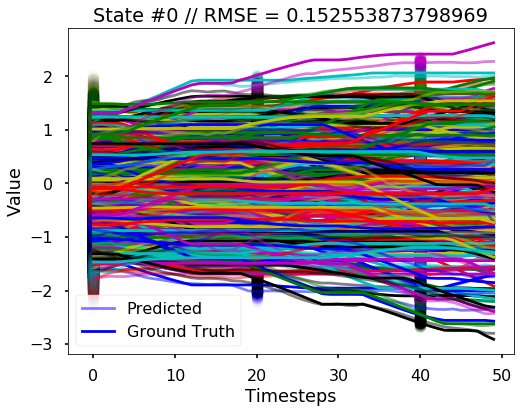

0.18363927925976306


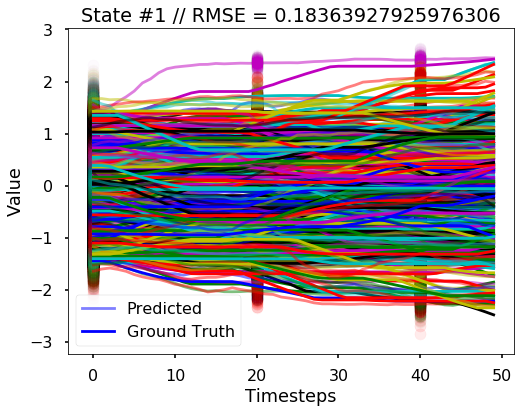

In [8]:
eval_experiment("dpf_omnipush")